In [1]:
from gensim.models import Doc2Vec
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
import numpy as np  
import sys
from sklearn import metrics

import pandas as pd
import random as rnd
from random import shuffle

sys.path.append('../')
from twitch import twitch_commons

%pylab inline
matplotlib.use('Agg')
import matplotlib
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
df = pd.read_csv('./user_chat_counts.csv.dat', header=None, names=['user', 'total', 'male', 'female'])
df['female_chat_percentage'] = (df.female*100)/df.total

print('all users: ' + str(len(df.index)))

print('users with atleast 100 messages: ' + str(len(df[df.total >= 100].index)))

selected_users = df[(df.total >= 100) & ((df.female_chat_percentage == 100) | (df.female_chat_percentage == 0))]
users = selected_users.user.tolist()
female_chat_percentages = selected_users.female_chat_percentage.tolist()

no_of_users = len(users)
print('filtered users: ' + str(no_of_users))

all users: 1718272
users with atleast 100 messages: 79982
filtered users: 77045


In [3]:
model = Doc2Vec.load('./user_chats.d2v')

feature_vectors = [model.docvecs[x] for x in users]

In [4]:
print(len(feature_vectors))

77045


### classification model

In [5]:
def build_classification_model(train_arrays, train_labels, test_arrays, test_lebels):
    classifier = LogisticRegression()
    classifier.fit(train_arrays, train_labels)
    print('model accuracy : ' + str(classifier.score(test_arrays, test_labels)))
    predict_score = classifier.predict_proba(test_arrays)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, predict_score)
    twitch_commons.plot_roc_curve(fpr, tpr)

model accuracy : 0.819873841601


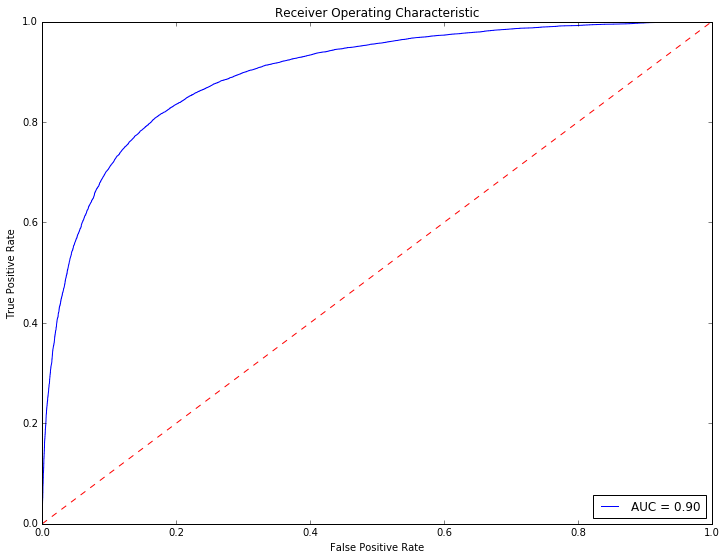

In [6]:
trainig_data_size = no_of_users//2
train_arrays = numpy.zeros((trainig_data_size, 100))
train_labels = numpy.zeros(trainig_data_size)
test_arrays = numpy.zeros((no_of_users-trainig_data_size, 100))
test_labels = numpy.zeros(no_of_users-trainig_data_size)

for i in range(trainig_data_size):
    train_arrays[i] = feature_vectors[i]
    train_labels[i] = 1 if female_chat_percentages[i] >= 50 else  0

for i in range(no_of_users - trainig_data_size):
    test_arrays[i] = feature_vectors[trainig_data_size+i]
    test_labels[i] = 1 if female_chat_percentages[trainig_data_size+i] >= 50 else  0
    
build_classification_model(train_arrays, train_labels, test_arrays, test_labels)

### clustering

In [7]:
records = rnd.sample(df[(df.total >= 100)].values.tolist(), 20000)
users_sample = [r[0] for r in records]
percentages = [int(r[4]) for r in records]
all_xy_vectors = twitch_commons.reduce_dim([model.docvecs[x] for x in users_sample], 'tsne')

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Explained variation per principal component: [ 0.02744124  0.02497047  0.01988368  0.01941926  0.01671336  0.01636701
  0.01571915  0.0147961   0.01424286  0.01383389  0.0133204   0.01305283
  0.01274654  0.01254133  0.01207643  0.0119894   0.01147534  0.01132337
  0.01124247  0.01102315  0.01096463  0.01086599  0.01073553  0.01065631
  0.01057532  0.01045802  0.01041957  0.01033231  0.01022081  0.01014314
  0.01009872  0.0100266   0.00998438  0.0098962   0.00982567  0.00978093
  0.00972606  0.00967958  0.00963995  0.00960073  0.00953021  0.00949988
  0.00936314  0.00934534  0.00931796  0.00930871  0.00924188  0.00919567
  0.00913161  0.00906995]
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 2

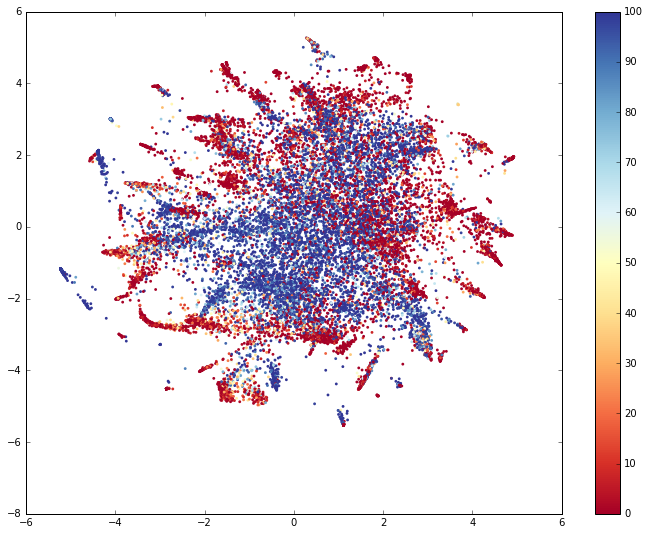

In [8]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter([x[0] for x in all_xy_vectors],[y[1] for y in all_xy_vectors], s=8, c=percentages, lw=0, cmap=cm)
plt.colorbar(sc)